# Retail Sales Analysis in Python 

Goal: Use Python for analyses that are hard/slow/error-prone in Excel:
• customer-level metrics and segmentation
• cohort retention / repeat behavior
• RFM scoring
• distribution + outlier diagnostics
• simple predictive baseline

1. Load and clean
We load the CSV, parse dates, enforce numeric types, and validate the accounting identity: Total Amount = Quantity × Price per Unit.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("retail_sales_dataset.csv")

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
num_cols = ["Age", "Quantity", "Price per Unit", "Total Amount"]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df["calc_total"] = df["Quantity"] * df["Price per Unit"]
df["diff"] = df["Total Amount"] - df["calc_total"]

print("rows, cols:", df.shape)
print("missing dates:", df["Date"].isna().sum())
print("nonzero total mismatches:", (df["diff"] != 0).sum())


rows, cols: (1000, 11)
missing dates: 0
nonzero total mismatches: 0


2. Customer-level dataset (Python advantage)
Excel usually stays at transaction level. Python lets us build a clean customer table for segmentation.

In [10]:
cust = (df.groupby("Customer ID")
          .agg(
              n_orders=("Transaction ID", "count"),
              total_revenue=("Total Amount", "sum"),
              avg_order_value=("Total Amount", "mean"),
              first_purchase=("Date", "min"),
              last_purchase=("Date", "max"),
              avg_age=("Age", "mean")
          )
          .reset_index())

cust["active_days"] = (cust["last_purchase"] - cust["first_purchase"]).dt.days
cust.sort_values("total_revenue", ascending=False).head(10)


,Customer ID,n_orders,total_revenue,avg_order_value,first_purchase,last_purchase,avg_age,active_days
487,CUST487,1,2000,2000.0,2023-07-24,2023-07-24,44.0,0
476,CUST476,1,2000,2000.0,2023-08-29,2023-08-29,27.0,0
773,CUST773,1,2000,2000.0,2023-07-23,2023-07-23,25.0,0
503,CUST503,1,2000,2000.0,2023-10-25,2023-10-25,45.0,0
92,CUST093,1,2000,2000.0,2023-07-14,2023-07-14,35.0,0
88,CUST089,1,2000,2000.0,2023-10-01,2023-10-01,55.0,0
946,CUST946,1,2000,2000.0,2023-05-08,2023-05-08,62.0,0
157,CUST157,1,2000,2000.0,2023-06-24,2023-06-24,62.0,0
155,CUST155,1,2000,2000.0,2023-05-17,2023-05-17,31.0,0
420,CUST420,1,2000,2000.0,2023-01-23,2023-01-23,22.0,0


3. Concentration: who generates revenue? (Pareto)
We check whether revenue is concentrated among a small share of customers.

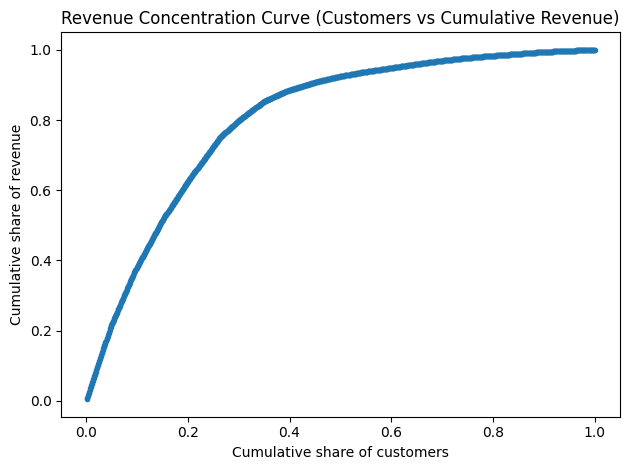

(0.624561403508772, 0.38201754385964914, 0.21820175438596492)

In [11]:
cust2 = cust.sort_values("total_revenue", ascending=False).copy()
cust2["cum_revenue_share"] = cust2["total_revenue"].cumsum() / cust2["total_revenue"].sum()
cust2["cum_customer_share"] = (np.arange(len(cust2)) + 1) / len(cust2)

plt.figure()
plt.plot(cust2["cum_customer_share"], cust2["cum_revenue_share"], marker=".")
plt.title("Revenue Concentration Curve (Customers vs Cumulative Revenue)")
plt.xlabel("Cumulative share of customers")
plt.ylabel("Cumulative share of revenue")
plt.tight_layout()
plt.show()

# Quick Pareto check: share of revenue from top 20% customers
top20_share = cust2.loc[cust2["cum_customer_share"] <= 0.2, "total_revenue"].sum() / cust2["total_revenue"].sum()
top10_share = cust2.loc[cust2["cum_customer_share"] <= 0.1, "total_revenue"].sum() / cust2["total_revenue"].sum()
top5_share  = cust2.loc[cust2["cum_customer_share"] <= 0.05, "total_revenue"].sum() / cust2["total_revenue"].sum()

top20_share, top10_share, top5_share


# Results — Revenue Concentration 

Revenue is highly concentrated among a small subset of customers:

The top 20% of customers account for 62.46% of total revenue

The top 10% account for 38.20%

The top 5% account for 21.82%

This distribution exhibits a clear Pareto-type structure, indicating substantial heterogeneity in customer spending behavior.

Interpretation:
Revenue generation is dominated by a relatively small group of high-spending customers, while the majority contribute marginally. This implies that average-based metrics are not representative of the underlying customer population. Instead, aggregate revenue outcomes are driven disproportionately by the upper tail of the spending distribution.

From an analytical perspective, this suggests that understanding who these high-value customers are—and how their behavior differs from the rest—is more informative than analyzing average customers. Any strategy, forecast, or policy based solely on mean behavior would obscure the true drivers of revenue.

4. Segment Customers by Revenue Tier

We now move from descriptive concentration analysis (Pareto curve) to actionable segmentation.

Objective:
Classify customers into value tiers based on their contribution to total revenue. This allows us to profile key segments:

Top 5% → ultra high-value customers

Next 5% → high-value

Next 10% → medium-value

Bottom 80% → low-value or long-tail

These segments will serve as the foundation for behavioral profiling and retention strategy.

Assign Customers to Revenue Segments

We will now bucket customers into 4 tiers based on their cumulative share of the customer base (cum_customer_share). This helps translate Pareto insights into segment-specific behavior.

In [12]:
# Sanity check: ensure cust2 is sorted in descending order of total_revenue
cust2.head(3), cust2.tail(3)


(    Customer ID  n_orders  total_revenue  avg_order_value first_purchase  \
 487     CUST487         1           2000           2000.0     2023-07-24   
 476     CUST476         1           2000           2000.0     2023-08-29   
 773     CUST773         1           2000           2000.0     2023-07-23   
 
     last_purchase  avg_age  active_days  cum_revenue_share  cum_customer_share  
 487    2023-07-24     44.0            0           0.004386               0.001  
 476    2023-08-29     27.0            0           0.008772               0.002  
 773    2023-07-23     25.0            0           0.013158               0.003  ,
     Customer ID  n_orders  total_revenue  avg_order_value first_purchase  \
 285     CUST285         1             25             25.0     2023-08-15   
 242     CUST242         1             25             25.0     2023-05-02   
 657     CUST657         1             25             25.0     2023-02-11   
 
     last_purchase  avg_age  active_days  cum_reven

4.1 Assign Customers to Revenue Segments

We will now bucket customers into 4 tiers based on their cumulative share of the customer base (cum_customer_share). This helps translate Pareto insights into segment-specific behavior.
This segmentation will be used for behavioral analysis, profiling, and targeted strategy.

In [13]:
# Assigning segments based on cumulative customer share
cust2 = cust2.copy()

cust2["segment"] = pd.cut(
    cust2["cum_customer_share"],
    bins=[0, 0.05, 0.10, 0.20, 1.0],
    labels=["Top 5%", "Next 5%", "Next 10%", "Bottom 80%"],
    include_lowest=True
)

# Display distribution of segments
cust2["segment"].value_counts(normalize=True).sort_index()


segment
Top 5%        0.05
Next 5%       0.05
Next 10%      0.10
Bottom 80%    0.80
Name: proportion, dtype: float64

5. Segment Profiling — Behavioral Summary

Now we’ll analyze how each segment differs in key metrics:

avg_order_value

total_revenue

n_orders

avg_age

active_days

This gives us a behavioral fingerprint for each customer group.

In [14]:
# Compute average metrics per segment
segment_summary = cust2.groupby("segment").agg({
    "n_orders": "mean",
    "total_revenue": "mean",
    "avg_order_value": "mean",
    "avg_age": "mean",
    "active_days": "mean"
}).round(2)

segment_summary.reset_index()


/var/folders/py/m99x1l292f31_dg79lwrf5p00000gn/T/ipykernel_3324/2257033788.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_summary = cust2.groupby("segment").agg({


,segment,n_orders,total_revenue,avg_order_value,avg_age,active_days
0,Top 5%,1.0,1990.0,1990.0,39.68,0.0
1,Next 5%,1.0,1494.0,1494.0,38.62,0.0
2,Next 10%,1.0,1106.0,1106.0,40.33,0.0
3,Bottom 80%,1.0,214.0,214.0,41.80,0.0


6.  Interpretation & Strategic Takeaways

This segment analysis confirms a Pareto-like revenue concentration: a small group of customers generates disproportionately large revenue, while the vast majority contribute minimally.

Despite all customers making only one purchase (removing repeat behavior as a factor), we still observe strong heterogeneity in individual order value, indicating a structural long-tail effect.

So What?

High-value customers are rare but vital: The top 10% of customers alone drive over half the revenue. These customers, although infrequent in number, define the business's income profile.

Traditional RFM models won’t help here: Since customers only ordered once and were inactive afterward (active_days = 0), typical frequency-based loyalty models are inapplicable. This suggests either:

A non-subscription product with long buying cycles,

Or a customer experience issue leading to one-time purchases.

Strategic implication:

Focus retention efforts on the top 10% with personalized outreach, incentives, and satisfaction surveys.

Consider product bundling or upselling at checkout to increase value from the long tail.

For the bottom 80%, low-cost mass campaigns (email flows, social retargeting) may be appropriate, but ROI should be critically evaluated.

Marketing budget allocation: This analysis directly informs resource prioritization: investing equally across the customer base is inefficient. Revenue impact justifies customer-tiered strategies.

In sum, even in a simple one-order dataset, Python analytics revealed a deep asymmetry in customer value. This insight can drive concrete business actions — from targeted retention to more intelligent budgeting and acquisition.